# **Importamos librerias**

In [1]:
import os
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Cargamos el conjunto de datos de prueba y entrenamiento al programa.
Mediante la ruta donde se encuentran guardadas las imágenes tanto de entrenamiento y prueba, podemos acceder a cada una de ellas, leerlas, guardarlas correctamente a la clase a la que pertenecen, en este caso en alguna de las siguientes 4:
* 1. Glioma
* 2. Meningioma
* 3. Pituitario
* 4. No tumor

Una vez que las imágenes se clasifican correctamente, se reescalan a un valor de (128,128) pixeles para trabajarlas en una escala normalizada.

In [2]:
#Rutas
path_train = ('Brain MRI/Training/')
path_test = ('Brain MRI/Testing/')

#Datos (X)
X = []
#Clases (y)
y = []
#Tamaño de imagenes
img_size = 128

# Lectura de datos de entrenamiento
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train+i)):
        X.append(cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        y.append(i)

#Lectura de datos de entrenamiento
for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test+i)):
        X.append(cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        y.append(i)

100%|██████████| 100/100 [00:00<00:00, 137.15it/s]


### Conversión de las imágenes a matrices
La computadora no sabe lo que es una imagen, pero lo puede interpretar mediante números, podemos asignar un valor de 0 a 255 a cada uno de los pixeles que conforman las imágenes y pasarlo como una matriz de números.
### Creación de los conjuntos de datos
Una vez que las imágenes se convierten a matrices, este será el conjunto de datos con todas las características que el modelo aprenderá para intentar clasificarlos correctamente de acuerdo con su clase "y".

También se convierten los datos "y", las etiquetas a una tabla que contenga las categorías, donde los 1 representan la clase a la que pertenece

In [3]:
#Conversion de las imagenes a un tensor (conjunto de matrices)
X = np.array(X)
#Conversion de las Clases a categorias
y = pd.get_dummies(y)
#Cantidad de datos, tamaño de las imanges y cantidad de canales RGB
print(X.shape)
#Nombres transformados en categorias
print(y.shape)

(3264, 128, 128, 3)
(3264, 4)


In [4]:
y

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
3259,1,0,0,0
3260,1,0,0,0
3261,1,0,0,0
3262,1,0,0,0


### Escalamiento de los datos
Para ahorrar espacio en memoria y tiempo de procesamiento, los datos se escalan en un factor de 1/255 que es valor máximo para intensidad de color en un pixel

In [5]:
X= X.astype('float32')
X[0][:1]
X/=255

### Visualizacion de un dato del conjunto X

AxesImage(54,36;334.8x217.44)


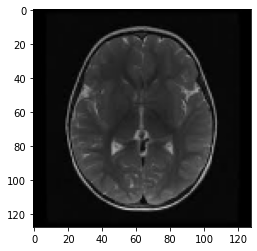

In [7]:
print(plt.imshow(X[233]))

# División de los datos
Normalmente los proyectos de Machine Learning utilizan 4 conjuntos de datos para su desarrollo:
* 1. Datos del conjunto X para entrenamiento
* 2. Datos del conjunto X para prueba
* 3. Datos del conjunto y para entrenamiento
* 4. Datos del conjunto y para prueba

La proporción que usualmente se ocupa es 70-80% de los datos son para el entrenamiento, y el restante 20-30% para pruebas.
En este caso se usó la proporción 80-20.

In [8]:
X_train, X_test,y_train, y_test= train_test_split(X, y, test_size= 0.2 , shuffle = True, random_state = 42)

### En este caso para tener más imagenes en el conjunto de pruebas, en vez de utilizar la cantidad de datos sugerido por Kaggle, se unieron los dos conjuntos de datos en uno solo y al divirlos en la proporción de 80-20, al final se obtuvo un conjunto de 2611 imagenes de entrenamiento y 653 para pruebas.

In [9]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((2611, 128, 128, 3), (653, 128, 128, 3), (2611, 4), (653, 4))

# Definición de la estructura de la Red Neuronal Convolutiva.
Declaramos el modelo de tipo "Sequential", que nos permite ir agregando los datos de forma secuencial.

* Comenzando por las capas `Conv2D`, son las capas de que llevan a cabo la operación de convolución, la que extrae las características de la imagen para aprender los patrones que caracterizan a cada una de las clases, lo hace mediante "kernels" que son filtros con valores que la misma red propone y va cambiando para lograr extraer las características más importantes en este caso para la primera y segunda capa se aplicaron `32` filtros de (2x2), en la tercera capa `128` filtros de (2*2),y en la cuarta capa `64` filtros de (3*3).

* después de cada capa de convolución se agrega una función de `activación` en este caso `Relu`, la cual básicamente lo que hace es desechar los pixeles con valores negativos resultantes de las operaciones de convolución aplicada por los "kernels" y a los valores positivos los deja tal como están. Esta función lo que permite es ir reduciendo el tamaño de la imagen para obtener las características cada vez más complejas.

* Las capas de `MaxPooling` son las que literalmente hacen la reducción de dimensión de la imagen para trabajar cada vez con menos parámetros.

* Las capas de `Dropout` apagan cierto porcentaje de neuronas para lograr que el entrenamiento sea más rígido, que no se sobreentrene y que el modelo pueda trabajar casos generales de imágenes, no solo los particulares con los que entreno.

* La capa `Flatten` genera un solo vector de neuronas tras obtener todas las características de las imágenes.

* La capa `Dense` es la que genera las conexiones de las características aprendidas para finalmente llegar a la capa de clasificación, en este caso se declararon dos de `128 y 64` neuronas. Estas también llevan la función de activación.

* La capa final también pertenece a la categoría `Dense`, con la diferencia de que contiene la función de activación `Softmax` la cual se encarga de asignar una probabilidad a cada categoria y escoger el valor más alto para determinar su categoría y solo `4` neuronas de salida que pertenecen a una de las 4 categorías de clasificación.


In [10]:

model = Sequential()


model.add(Conv2D(32, (2, 2), padding='same', input_shape=(128,128,3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(128, (2, 2), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(4, Activation('softmax')))


### Resumen del modelo
La libreria nos permite mostrar un resumen de los parametros que utilizara para entrenar, el cual sera explicado en el apartado de resultados para darle sentido a todos los datos.

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      416       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 32)      4128      
_________________________________________________________________
activation_1 (Activation)    (None, 127, 127, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 128)       1

 # Compilar el modelo
 En este caso se define una función de `optimización`, la cual nos permite establecer que el modelo aprendió a un ritmo considerablemente lento para que logre hacerlo mucho mejor.
 
 Definimos la función que permite medir las perdidas en el proceso de entrenamiento y la métrica a medir que es la exactitud, finalmente le damos los parámetros que son los datos de entrenamiento y prueba.
 
 El entrenamiento se llevará a cabo en 25 épocas, el número de épocas es un parámetro que define el número de veces que el algoritmo trabajará a través de todo el conjunto de datos de entrenamiento. Una época significa que cada muestra del conjunto de datos de entrenamiento ha tenido la oportunidad de actualizar los parámetros internos del modelo.


In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
opt = Adam(learning_rate=0.0001) 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size=32, epochs=25,validation_data=(X_test,y_test),verbose=1,callbacks=[tensorboard,checkpoint])


Epoch 1/25
82/82 [==============================] - 11s 39ms/step - loss: 1.2711 - accuracy: 0.4133 - val_loss: 1.1818 - val_accuracy: 0.5130

Epoch 00001: val_accuracy improved from -inf to 0.51302, saving model to cnn.h5
Epoch 2/25
82/82 [==============================] - 2s 25ms/step - loss: 1.1534 - accuracy: 0.4925 - val_loss: 1.0780 - val_accuracy: 0.5666

Epoch 00002: val_accuracy improved from 0.51302 to 0.56662, saving model to cnn.h5
Epoch 3/25
82/82 [==============================] - 2s 27ms/step - loss: 1.0279 - accuracy: 0.5584 - val_loss: 0.9064 - val_accuracy: 0.6371

Epoch 00003: val_accuracy improved from 0.56662 to 0.63706, saving model to cnn.h5
Epoch 4/25
82/82 [==============================] - 2s 27ms/step - loss: 0.9246 - accuracy: 0.5998 - val_loss: 0.8428 - val_accuracy: 0.6600

Epoch 00004: val_accuracy improved from 0.63706 to 0.66003, saving model to cnn.h5
Epoch 5/25
82/82 [==============================] - 2s 27ms/step - loss: 0.8322 - accuracy: 0.6339 - v

# Evaluación en el conjunto de datos de prueba

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Perdidas en conjunto de pruebas:', loss)
print('Exactitud en conjunto de pruebas:', accuracy)


21/21 [==============================] - 0s 8ms/step - loss: 0.3514 - accuracy: 0.9035
Perdidas en conjunto de pruebas: 0.3514367938041687
Exactitud en conjunto de pruebas: 0.9035221934318542


# Graficas de exactitud y perdida

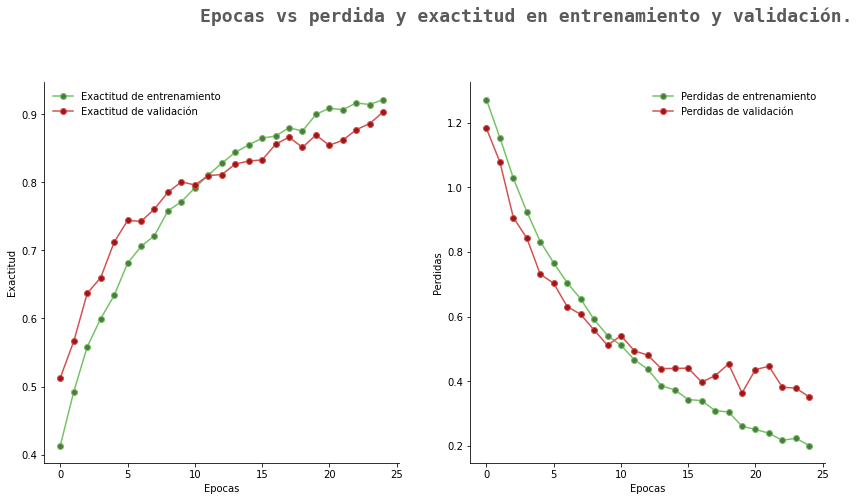

In [14]:

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(25)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epocas vs perdida y exactitud en entrenamiento y validación.',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Exactitud de entrenamiento')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Exactitud de validación')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epocas')
ax[0].set_ylabel('Exactitud')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Perdidas de entrenamiento')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Perdidas de validación')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epocas')
ax[1].set_ylabel('Perdidas')

fig.show()


In [15]:
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis=1)
y_test_new = np.argmax(y_test.to_numpy(),axis=1)
y_test_new

array([1, 2, 3, 2, 3, 1, 3, 1, 3, 2, 1, 1, 3, 0, 3, 0, 0, 1, 0, 2, 1, 2,
       2, 3, 3, 0, 1, 3, 2, 2, 1, 2, 3, 1, 2, 0, 3, 1, 2, 1, 1, 0, 0, 2,
       3, 3, 1, 2, 3, 2, 3, 3, 1, 1, 1, 3, 3, 2, 1, 3, 1, 2, 3, 0, 3, 3,
       1, 3, 0, 3, 0, 3, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 0, 3, 2, 0, 0,
       3, 1, 0, 2, 2, 1, 2, 1, 0, 3, 2, 0, 3, 2, 3, 1, 2, 0, 3, 0, 1, 0,
       1, 2, 3, 0, 0, 0, 0, 3, 1, 1, 3, 0, 1, 2, 0, 1, 3, 3, 0, 1, 3, 0,
       3, 0, 3, 3, 1, 0, 0, 0, 0, 1, 3, 2, 1, 1, 3, 2, 3, 1, 1, 2, 2, 0,
       3, 3, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1, 3, 0, 0, 0, 1, 3, 3, 1, 1, 0,
       0, 2, 0, 2, 1, 2, 2, 1, 0, 3, 2, 1, 2, 0, 1, 3, 1, 3, 0, 1, 0, 2,
       1, 1, 3, 1, 1, 0, 2, 2, 3, 1, 0, 2, 3, 0, 1, 3, 0, 3, 3, 0, 1, 1,
       3, 0, 1, 3, 2, 1, 3, 2, 3, 1, 2, 2, 3, 0, 1, 2, 0, 0, 2, 2, 3, 3,
       0, 1, 0, 2, 0, 1, 3, 3, 2, 3, 3, 2, 0, 2, 2, 1, 3, 1, 3, 0, 1, 3,
       1, 2, 3, 0, 1, 0, 0, 1, 2, 1, 3, 0, 2, 0, 2, 0, 1, 1, 1, 3, 1, 2,
       3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 3, 1, 2, 0, 0,

# Reporte de clasificación.
En este caso los valores que arroja el reporte de clasificacion son los siguientes:
* Precisión: es la medida de qué tan bien la red neuronal convolucional identifica positivos verdaderos (TP) en comparación con falsos positivos (FP). 
* Recall: es la medida de qué tan bien la red neuronal convolucional identifica TP en comparación con falsos negativos (FN). 
* F1-score: es la media armónica entre la precisión y el recall. Es una medida de la precisión general del modelo.

TP, FP, TN y FN se refieren a los diferentes tipos de predicciones que se pueden hacer al evaluar
* TP (verdaderos positivos) se refiere a la cantidad de casos positivos que se clasifican correctamente como positivos.
* FP (falsos positivos) se refiere a la cantidad de casos negativos que se clasifican incorrectamente.
* TN (verdaderos negativos) se refiere a la cantidad de casos negativos que se clasifican correctamente como negativos.
* FN (falsos negativos) se refiere a la cantidad de casos positivos que se clasifican incorrectamente como negativo.


In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       162
           1       0.86      0.89      0.87       180
           2       0.87      0.89      0.88       122
           3       0.94      0.97      0.95       189

    accuracy                           0.90       653
   macro avg       0.90      0.90      0.90       653
weighted avg       0.90      0.90      0.90       653



# Matriz de confusión
Es una tabla que muestra el número de predicciones correctas e incorrectas para cada clase. 
En la diagonal se encuentran los verdaderos positivos, los datos abajo de la diagonal corresponden a los falsos negativos y los datos arriba de la diagonal corresponden a los falsos positivos

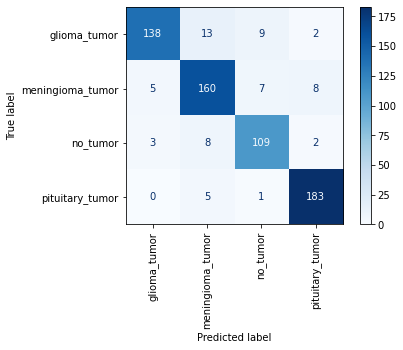

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred,display_labels=y_train.columns,
                                        cmap='Blues', xticks_rotation="vertical");